**Sawyer Strong & Erik Cohen**

Fall 2019

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

**Draft due 11:59pm Thurs Sept 26**


Summary of files in this project:
- `softmax_layer.ipynb`
- `single_layer_net.py`
- `preprocess_data.py`
- `mlp.ipynb`
- `mlp.py`

**REMINDER**: Submit rubric on Google Classroom

In [1]:

import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Overview

In this project, you will implement Multilayer Perception (MLP) networks that classify image data belonging to one of 10 classes from the STL-10 dataset. 

You will create two networks that use the softmax activation function and cross-entropy loss: 

- One without a hidden layer (**Task 2**; this notebook) and 
- One with a hidden layer (**Task 3**; ``mlp.ipynb``)

Before implementing the MLP with hidden layer, we will create a simpler single layer network (similar architecture to ADALINE) to test your loss and activation function code.

Focus areas in this project are:
- Working with a large dataset
- Batch vs stochastic training
- Regularization
- Multi-class data classification
- Network weight visualization

## Task 1) Download and preprocess datasets


### a. STL-10

More info: https://cs.stanford.edu/~acoates/stl10/

**Properties:**
- 10 classes of images: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck
- 5000 images.
- 96x96 resolution (we will work with them converted to 32x32 for rapid development and debugging purposes)


#### (i) Download the STL-10 dataset, convert to 32x32 images

This data acquistion script should "just work". You're welcome to take a peek at the script to see where the data is going, but you shouldn't need to tinker with it. It needs to download the dataset from the internet, which might take a few minutes. I set up the script so that it caches the dataset locally in your project folder, so you should only need to download it once. There is a progress percentage indicator.

You should see the following output:

`Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
`

In [2]:
# Download the dataset from the internet, convert it to Numpy ndarray, resize to 32x32
# cache it locally on your computer for faster loading next time.
stl_imgs, stl_labels = load_stl10_dataset.load()

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)


#### (ii) Take a look at a sample of the images in the dataset

Let's take a look at the image categories that we want the neural network to learn

In [3]:
# Load in the string names for each class
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

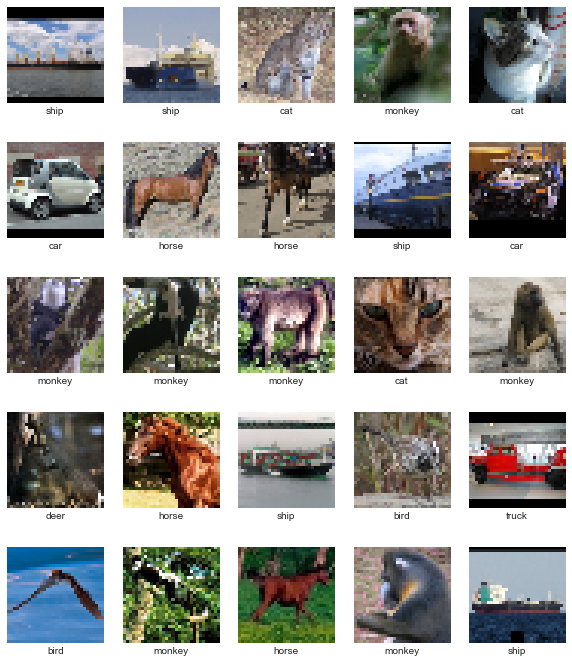

In [4]:
plt.figure(figsize=(10, 12))
plt.subplot
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    randInd = random.randint(0, len(stl_imgs)-1)
    plt.imshow(stl_imgs[randInd])
    plt.xlabel(classes[stl_labels[randInd]-1])
plt.show()

#### (iii) Preprocess the data

Preprocessing data is an important part of working with neural networks. 

**TODO**: Fill in the function `preprocess_stl` in `preprocess_data.py`, implementing the 4 listed goals, to get the desired print out below.

In [5]:
# Preprocess image pixel values for the MLP net
stl_imgs, stl_labels = preprocess_data.preprocess_stl(stl_imgs, stl_labels)

print(f'stl_imgs dtype is {stl_imgs.dtype} and it should be float64')
print(f'stl_imgs max is {np.max(stl_imgs[:, 1:]):.3f} and it should be 0.668')
print(f'stl_imgs shape is {stl_imgs.shape} and it should be (5000, 3072)')
print(f'stl_labels span {stl_labels.min()}->{stl_labels.max()} and it should be 0->9')

stl_imgs dtype is float64 and it should be float64
stl_imgs max is 0.668 and it should be 0.668
stl_imgs shape is (5000, 3072) and it should be (5000, 3072)
stl_labels span 0->9 and it should be 0->9


#### (iii) Create train, validation, test, and dev splits

**TODO**: Complete the `create_splits` function in `preprocess_data.py` to divvy up the dataset into train/test/validation/development subsets, following the two main goals lists. You should obtain a printout as follows:

`Train data shape:  (3500, 3072)
Train labels shape:  (3500,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)
Validation data shape:  (500, 3072)
Validation labels shape:  (500,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)
`

In [6]:
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.create_splits(stl_imgs, stl_labels)  

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (3500, 3072)
Train labels shape:  (3500,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)
Validation data shape:  (500, 3072)
Validation labels shape:  (500,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


## Task 2) Implement single layer network to test softmax activation and cross-entropy loss

You will first implement and test out the softmax activation and cross-entropy loss in a single layer net before embedding it in a more complex multiple layer network.

### a. Implement the following functions

In `single_layer_net.py`, implement the following methods in the base class `SingleLayerNet`:

- `fit`
- `net_in`
- `predict`
- `one_hot`
- `accuracy`


In the child class `SingleLayerNetSoftmax` implement the following methods:

- `activation` (softmax) $f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}}$ where $x_i$ are the "net in" values and there are $C$ output neurons (one per input class). $f(x_i)$ is the activation values of each output neuron $i$. Since this is softmax, it is the probability that a given input belongs to the class $i$ coded by the output neuron.
- `loss` (cross-entropy) $L(x_m) = -\frac{1}{B}\sum_{b=1}^B{Log \left (\frac{e^{x_m}}{\sum_{n=1}^C e^{x_n}}\right )}$. $m$ is the correct class for the $b^{th}$ input. $x_m$ is the output neuron activation for the correct class, $x_n$ is the output neuron activation for all of the classes (in the sum). The batch size is $B$, so the loss is averaged over each mini-batch of inputs. The expression in the $Log$ is just the softmax.
- `gradient` (for softmax/cross-entropy)

You're welcome to work in any order, but I recommend starting with `fit` because as you work though it, you should recognize why we need most of the other methods. You can finish `fit` or branch off as you need the other methods.

### b. Test key functions

In [7]:
from single_layer_net import SingleLayerNetSoftmax

In [8]:
# Let's generate some small Gaussian weights equal to the length of an image feature vector
np.random.seed(0)
randWts = np.random.normal(loc=0, scale=0.01, size=(x_dev.shape[1], 10))
b = 1
softmaxNet = SingleLayerNetSoftmax()
randWts.shape

# for test code purposes, use the last 15 images/labels
test_imgs, test_labels = stl_imgs[-15:], stl_labels[-15:]

#### Test the `onehot` function

In [9]:
not_y_test = np.array([2, 2, 0, 1])
c_test = 4
y_one_hot = softmaxNet.one_hot(not_y_test, c_test)
print(f'Your one hot vectors:\n{y_one_hot}')

Your one hot vectors:
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


Your one hot vectors should look like:

    [[0. 0. 1. 0.]
     [0. 0. 1. 0.]
     [1. 0. 0. 0.]
     [0. 1. 0. 0.]]

#### Test the `loss`,  `net_in`, softmax `activation` functions

In [10]:
lossNoReg, lossReg = softmaxNet.test_loss(randWts, b, test_imgs, test_labels)
print(f'The loss (without regularization) is {lossNoReg:.2f} and it should approx be 2.28')
print(f'The loss (with 0.5 regularization) is {lossReg:.2f} and it should approx be 3.04')

net in shape=(15, 10), min=0.6586955718394151, max=1.4084436090585781
Should be
net in shape=(15, 10), min=0.6586955718394152, max=1.4084436090585783

net act shape=(15, 10), min=0.07413774498031761, max=0.1416742376747235
Should be
net act shape=(15, 10), min=0.07413774498031761, max=0.14167423767472354

The loss (without regularization) is 2.28 and it should approx be 2.28
The loss (with 0.5 regularization) is 3.04 and it should approx be 3.04


#### Test the `gradient` function

In [11]:
grad_wts, grad_b = softmaxNet.test_gradient(randWts, b, test_imgs, test_labels, 10)
print(f'1st few Wt gradient values are {grad_wts[:4,0]}\nand should be                  [0.01  0.015 0.014 0.007] ')
print(f'1st few Wt bias values are {grad_b[:4]}\nand should be              [ 0.103 -0.099  0.101 -0.026]')

net in: (15, 10), 0.6586955718394151, 1.4084436090585781
y one hot: (15, 10), sum is 15.0
1st few Wt gradient values are [0.01  0.015 0.014 0.007]
and should be                  [0.01  0.015 0.014 0.007] 
1st few Wt bias values are [ 0.103 -0.099  0.101 -0.026]
and should be              [ 0.103 -0.099  0.101 -0.026]


#### Test `fit` function

In [12]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250)

Starting to train network...There will be 600 epochs and 1200 iterations total, 2 iter/epoch.
  Completed iter 0/1200. Training loss: 2.31.
  Completed iter 100/1200. Training loss: 2.32.
  Completed iter 200/1200. Training loss: 2.29.
  Completed iter 300/1200. Training loss: 2.26.
  Completed iter 400/1200. Training loss: 2.24.
  Completed iter 500/1200. Training loss: 2.23.
  Completed iter 600/1200. Training loss: 2.23.
  Completed iter 700/1200. Training loss: 2.24.
  Completed iter 800/1200. Training loss: 2.19.
  Completed iter 900/1200. Training loss: 2.21.
  Completed iter 1000/1200. Training loss: 2.17.
  Completed iter 1100/1200. Training loss: 2.18.
Finished training!


Given the random mini-batch sampling process, you should get different specific numbers, but the loss should decrease with iterations. You should get something like this:

    Starting to train network...There will be 600 epochs and 1200 iterations total, 2 iter/epoch.
      Completed iter 0/1200. Training loss: 2.29.
      Completed iter 100/1200. Training loss: 2.30.
      Completed iter 200/1200. Training loss: 2.27.
      Completed iter 300/1200. Training loss: 2.29.
      Completed iter 400/1200. Training loss: 2.27.
      Completed iter 500/1200. Training loss: 2.23.
      Completed iter 600/1200. Training loss: 2.23.
      Completed iter 700/1200. Training loss: 2.23.
      Completed iter 800/1200. Training loss: 2.21.
      Completed iter 900/1200. Training loss: 2.20.
      Completed iter 1000/1200. Training loss: 2.20.
      Completed iter 1100/1200. Training loss: 2.17.
    Finished training!

##### Plot the loss. 

It should look noisy, but on average be decreasing and look roughly linear.

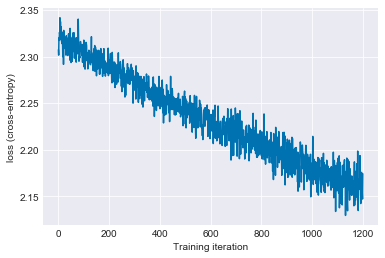

In [13]:
def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()
    
plot_cross_entropy_loss(loss_history)

**Question 1**: What do you think the linear drop in loss over the epochs tells us about the state of the training process? How is current training going? What's the future potential like?

**Answer:** The linear drop suggests that training is currently incomplete. We could increase the accuracy of the model by training for more epochs, or speed up training with a slightly larger learning rate.

#### Test regularization with training. The loss should hover around 17-18 for `reg=10`

**Question 2**: Play around with the regularization parameter. You can drastically change the magnitude, but it should remain positive. How does this affect the training loss and why?

**Answer:** Increasing the regularization parameter can drastically increase loss, while reducing the regularization parameter decreases the loss, asymptotically approaching a minimum value. This is because the regularization term is an additive one.

Starting to train network...There will be 500 epochs and 500 iterations total, 1 iter/epoch.
  Completed iter 0/500. Training loss: 17.77.
  Completed iter 100/500. Training loss: 14.94.
  Completed iter 200/500. Training loss: 12.64.
  Completed iter 300/500. Training loss: 10.76.
  Completed iter 400/500. Training loss: 9.21.
Finished training!


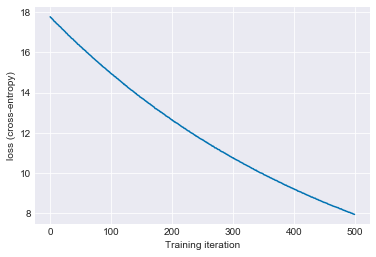

In [14]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, reg=10, n_epochs=500)
plot_cross_entropy_loss(loss_history)

#### Test training batch size

**Question 3**: Play around with the batch size parameter. **How does this affect the training loss and why?** (Think about the error gradient and how the weights change)

**Answer:** The bigger the batch size, the less oscilation that we can see in the loss function. This is a result of the model not making changes based on smaller sets of images and then finding different changes to make on other sets of images. This is why, as we increase the batch size, we see a siginificantly smoother loss curve over iterations.

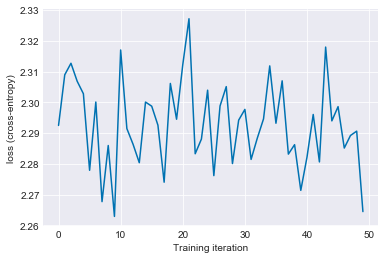

In [15]:
softmaxNet = SingleLayerNetSoftmax()
loss_history = softmaxNet.fit(x_dev, y_dev, mini_batch_sz=100, n_epochs=10, verbose=0);
plot_cross_entropy_loss(loss_history)

### c. Train and optimize STL-10 dataset performance, plot results

#### (i) Grid search

As you've surely noticed, hyperparameters can drastically affect learning! 


**TODO:** Implement a grid search for the best hyperparameters

- learning rate,
- regularization
- batch size 

The grid search process should:

1. Fit the model with specific values of hyperparameters that we're testing (using the training set).
2. Compute the accuracy on the training set. 
3. Compute the accuracy on the validation set. 
4. Print out and record the best parameter combination as you go (that improves the **validation set accuracy**).
5. Wipe the weights clean (reinitialize them) every time you try new parameters. It's easiest just to create a new net object on each run.


This can take quite a bit of simulation time!

I suggest implementing the coarse-to-fine search strategy. First try varying parameters over many orders of magnitude. Use the "new best" print outs to refine the ranges that you test. Abort simulations prematurely if you feel there aren't productive (no reason to wait!). This can take however long or short that you want to dedicate. Remember, you are printing out the best parameter values on each run, so you can just proceed with those.

You should be able to achieve ~35% accuracy without too much effort (10% is chance performance).

Your grade won't depend on the accuracy that you achieve, but if you get roughly the above accuracy, the payoff will be cooler visualizations in 2d!

##### Guidelines
- Learning rates above 1e-1 don't really make sense.
- Your mini-batch sizes should be <= N and >= 1

In [24]:
np.random.seed(0)

#Store the best values
best_val_acc = 0
best_lr = 0
best_reg = 0
best_batch = 0

#Set the initial values for the hyperparams
init_lr = 0.0501
init_reg = 50
init_batch = 501

#Set the values for the intervals at we'll search across, for each hyperparam
#These will be halved every time the search gets finer
lr_interval = 0.005
reg_interval = 5
batch_interval = 50

#Implement coarse-to-fine search for each hyperparameter
#An outer for loop in which we adjust the intervals and initial values for each search
#An inner triple-for-loop in which we search using the given intervals and inital values

for i in range(3):
    
    best_acc = 0
    
    #Search across learning rate
    for j in range(-10,11,2):
        lr = init_lr+(lr_interval*j)
        
        #Search across batch_size
        for k in range(-8,9,2):
            batch = max(10,int(init_batch+(batch_interval*k)))
            
            #Search across reg val
            for l in range(-10,11,2):
                reg = init_reg+(reg_interval*l)
                                
                #Train
                softmaxNet = SingleLayerNetSoftmax()
                softmaxNet.fit(x_train, y_train, 10, lr, batch, reg, 0)

                #Compute accuracy
                train_pred = softmaxNet.predict(x_train)
                val_pred = softmaxNet.predict(x_val)
                train_acc = softmaxNet.accuracy(y_train,train_pred)
                val_acc = softmaxNet.accuracy(y_val,val_pred)
                
                print(f"Zoom Level: {i+1}\tLr: {lr:5f}\tReg: {reg:5f}\tBatch: {batch}\tAcc: {val_acc:5f}")
                
                

                #Update best if needed
                if val_acc > best_acc:                    
                    best_acc = val_acc
                    best_lr = lr
                    best_reg = reg
                    best_batch = batch

    init_lr = best_lr
    lr_interval = lr_interval/2
    init_reg = best_reg
    reg_interval = reg_interval/2
    init_batch = best_batch
    batch_interval = batch_interval/2

print(f"The best learning rate was {best_lr}")
print(f"The best batch-size was {best_batch}")
print(f"The best regularization value was {best_reg}")

Zoom Level: 1	Lr: 0.000100	Reg: 0.000000	Batch: 101	Acc: 0.210000
Zoom Level: 1	Lr: 0.000100	Reg: 10.000000	Batch: 101	Acc: 0.182000
Zoom Level: 1	Lr: 0.000100	Reg: 20.000000	Batch: 101	Acc: 0.184000
Zoom Level: 1	Lr: 0.000100	Reg: 30.000000	Batch: 101	Acc: 0.168000
Zoom Level: 1	Lr: 0.000100	Reg: 40.000000	Batch: 101	Acc: 0.194000
Zoom Level: 1	Lr: 0.000100	Reg: 50.000000	Batch: 101	Acc: 0.222000
Zoom Level: 1	Lr: 0.000100	Reg: 60.000000	Batch: 101	Acc: 0.226000
Zoom Level: 1	Lr: 0.000100	Reg: 70.000000	Batch: 101	Acc: 0.242000
Zoom Level: 1	Lr: 0.000100	Reg: 80.000000	Batch: 101	Acc: 0.220000
Zoom Level: 1	Lr: 0.000100	Reg: 90.000000	Batch: 101	Acc: 0.260000
Zoom Level: 1	Lr: 0.000100	Reg: 100.000000	Batch: 101	Acc: 0.248000
Zoom Level: 1	Lr: 0.000100	Reg: 0.000000	Batch: 201	Acc: 0.166000
Zoom Level: 1	Lr: 0.000100	Reg: 10.000000	Batch: 201	Acc: 0.170000
Zoom Level: 1	Lr: 0.000100	Reg: 20.000000	Batch: 201	Acc: 0.154000
Zoom Level: 1	Lr: 0.000100	Reg: 30.000000	Batch: 201	Acc: 0.180

Zoom Level: 1	Lr: 0.010100	Reg: 20.000000	Batch: 301	Acc: 0.264000
Zoom Level: 1	Lr: 0.010100	Reg: 30.000000	Batch: 301	Acc: 0.256000
Zoom Level: 1	Lr: 0.010100	Reg: 40.000000	Batch: 301	Acc: 0.268000
Zoom Level: 1	Lr: 0.010100	Reg: 50.000000	Batch: 301	Acc: 0.266000
Zoom Level: 1	Lr: 0.010100	Reg: 60.000000	Batch: 301	Acc: 0.224000
Zoom Level: 1	Lr: 0.010100	Reg: 70.000000	Batch: 301	Acc: 0.268000
Zoom Level: 1	Lr: 0.010100	Reg: 80.000000	Batch: 301	Acc: 0.230000
Zoom Level: 1	Lr: 0.010100	Reg: 90.000000	Batch: 301	Acc: 0.246000
Zoom Level: 1	Lr: 0.010100	Reg: 100.000000	Batch: 301	Acc: 0.228000
Zoom Level: 1	Lr: 0.010100	Reg: 0.000000	Batch: 401	Acc: 0.316000
Zoom Level: 1	Lr: 0.010100	Reg: 10.000000	Batch: 401	Acc: 0.258000
Zoom Level: 1	Lr: 0.010100	Reg: 20.000000	Batch: 401	Acc: 0.268000
Zoom Level: 1	Lr: 0.010100	Reg: 30.000000	Batch: 401	Acc: 0.270000
Zoom Level: 1	Lr: 0.010100	Reg: 40.000000	Batch: 401	Acc: 0.272000
Zoom Level: 1	Lr: 0.010100	Reg: 50.000000	Batch: 401	Acc: 0.25

/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:279: RuntimeWarning: divide by zero encountered in log
  log_act = np.log(self.activation(net_in))


Zoom Level: 1	Lr: 0.020100	Reg: 100.000000	Batch: 101	Acc: 0.082000
Zoom Level: 1	Lr: 0.020100	Reg: 0.000000	Batch: 201	Acc: 0.352000
Zoom Level: 1	Lr: 0.020100	Reg: 10.000000	Batch: 201	Acc: 0.286000
Zoom Level: 1	Lr: 0.020100	Reg: 20.000000	Batch: 201	Acc: 0.258000
Zoom Level: 1	Lr: 0.020100	Reg: 30.000000	Batch: 201	Acc: 0.240000
Zoom Level: 1	Lr: 0.020100	Reg: 40.000000	Batch: 201	Acc: 0.254000
Zoom Level: 1	Lr: 0.020100	Reg: 50.000000	Batch: 201	Acc: 0.246000
Zoom Level: 1	Lr: 0.020100	Reg: 60.000000	Batch: 201	Acc: 0.218000
Zoom Level: 1	Lr: 0.020100	Reg: 70.000000	Batch: 201	Acc: 0.204000
Zoom Level: 1	Lr: 0.020100	Reg: 80.000000	Batch: 201	Acc: 0.224000
Zoom Level: 1	Lr: 0.020100	Reg: 90.000000	Batch: 201	Acc: 0.124000
Zoom Level: 1	Lr: 0.020100	Reg: 100.000000	Batch: 201	Acc: 0.072000
Zoom Level: 1	Lr: 0.020100	Reg: 0.000000	Batch: 301	Acc: 0.334000
Zoom Level: 1	Lr: 0.020100	Reg: 10.000000	Batch: 301	Acc: 0.268000
Zoom Level: 1	Lr: 0.020100	Reg: 20.000000	Batch: 301	Acc: 0.27

Zoom Level: 1	Lr: 0.030100	Reg: 10.000000	Batch: 401	Acc: 0.282000
Zoom Level: 1	Lr: 0.030100	Reg: 20.000000	Batch: 401	Acc: 0.286000
Zoom Level: 1	Lr: 0.030100	Reg: 30.000000	Batch: 401	Acc: 0.252000
Zoom Level: 1	Lr: 0.030100	Reg: 40.000000	Batch: 401	Acc: 0.248000
Zoom Level: 1	Lr: 0.030100	Reg: 50.000000	Batch: 401	Acc: 0.238000
Zoom Level: 1	Lr: 0.030100	Reg: 60.000000	Batch: 401	Acc: 0.194000
Zoom Level: 1	Lr: 0.030100	Reg: 70.000000	Batch: 401	Acc: 0.042000
Zoom Level: 1	Lr: 0.030100	Reg: 80.000000	Batch: 401	Acc: 0.034000
Zoom Level: 1	Lr: 0.030100	Reg: 90.000000	Batch: 401	Acc: 0.086000
Zoom Level: 1	Lr: 0.030100	Reg: 100.000000	Batch: 401	Acc: 0.066000
Zoom Level: 1	Lr: 0.030100	Reg: 0.000000	Batch: 501	Acc: 0.362000
Zoom Level: 1	Lr: 0.030100	Reg: 10.000000	Batch: 501	Acc: 0.290000
Zoom Level: 1	Lr: 0.030100	Reg: 20.000000	Batch: 501	Acc: 0.258000
Zoom Level: 1	Lr: 0.030100	Reg: 30.000000	Batch: 501	Acc: 0.260000
Zoom Level: 1	Lr: 0.030100	Reg: 40.000000	Batch: 501	Acc: 0.21

/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:283: RuntimeWarning: overflow encountered in double_scalars
  loss = ((-1/N) * np.sum(correct_loss)) + ((1/2) * reg * np.sum(np.square(self.wts)))
/Users/dhruv/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:283: RuntimeWarning: overflow encountered in square
  loss = ((-1/N) * np.sum(correct_loss)) + ((1/2) * reg * np.sum(np.square(self.wts)))


Zoom Level: 1	Lr: 0.040100	Reg: 100.000000	Batch: 101	Acc: 0.080000
Zoom Level: 1	Lr: 0.040100	Reg: 0.000000	Batch: 201	Acc: 0.364000
Zoom Level: 1	Lr: 0.040100	Reg: 10.000000	Batch: 201	Acc: 0.268000
Zoom Level: 1	Lr: 0.040100	Reg: 20.000000	Batch: 201	Acc: 0.256000
Zoom Level: 1	Lr: 0.040100	Reg: 30.000000	Batch: 201	Acc: 0.242000
Zoom Level: 1	Lr: 0.040100	Reg: 40.000000	Batch: 201	Acc: 0.224000
Zoom Level: 1	Lr: 0.040100	Reg: 50.000000	Batch: 201	Acc: 0.034000
Zoom Level: 1	Lr: 0.040100	Reg: 60.000000	Batch: 201	Acc: 0.066000
Zoom Level: 1	Lr: 0.040100	Reg: 70.000000	Batch: 201	Acc: 0.064000
Zoom Level: 1	Lr: 0.040100	Reg: 80.000000	Batch: 201	Acc: 0.118000
Zoom Level: 1	Lr: 0.040100	Reg: 90.000000	Batch: 201	Acc: 0.040000
Zoom Level: 1	Lr: 0.040100	Reg: 100.000000	Batch: 201	Acc: 0.072000
Zoom Level: 1	Lr: 0.040100	Reg: 0.000000	Batch: 301	Acc: 0.354000
Zoom Level: 1	Lr: 0.040100	Reg: 10.000000	Batch: 301	Acc: 0.262000
Zoom Level: 1	Lr: 0.040100	Reg: 20.000000	Batch: 301	Acc: 0.28

Zoom Level: 1	Lr: 0.050100	Reg: 10.000000	Batch: 401	Acc: 0.288000
Zoom Level: 1	Lr: 0.050100	Reg: 20.000000	Batch: 401	Acc: 0.286000
Zoom Level: 1	Lr: 0.050100	Reg: 30.000000	Batch: 401	Acc: 0.222000
Zoom Level: 1	Lr: 0.050100	Reg: 40.000000	Batch: 401	Acc: 0.064000
Zoom Level: 1	Lr: 0.050100	Reg: 50.000000	Batch: 401	Acc: 0.058000
Zoom Level: 1	Lr: 0.050100	Reg: 60.000000	Batch: 401	Acc: 0.112000
Zoom Level: 1	Lr: 0.050100	Reg: 70.000000	Batch: 401	Acc: 0.054000
Zoom Level: 1	Lr: 0.050100	Reg: 80.000000	Batch: 401	Acc: 0.092000
Zoom Level: 1	Lr: 0.050100	Reg: 90.000000	Batch: 401	Acc: 0.092000
Zoom Level: 1	Lr: 0.050100	Reg: 100.000000	Batch: 401	Acc: 0.096000
Zoom Level: 1	Lr: 0.050100	Reg: 0.000000	Batch: 501	Acc: 0.368000
Zoom Level: 1	Lr: 0.050100	Reg: 10.000000	Batch: 501	Acc: 0.294000
Zoom Level: 1	Lr: 0.050100	Reg: 20.000000	Batch: 501	Acc: 0.258000
Zoom Level: 1	Lr: 0.050100	Reg: 30.000000	Batch: 501	Acc: 0.266000
Zoom Level: 1	Lr: 0.050100	Reg: 40.000000	Batch: 501	Acc: 0.10

Zoom Level: 1	Lr: 0.060100	Reg: 30.000000	Batch: 601	Acc: 0.070000
Zoom Level: 1	Lr: 0.060100	Reg: 40.000000	Batch: 601	Acc: 0.056000
Zoom Level: 1	Lr: 0.060100	Reg: 50.000000	Batch: 601	Acc: 0.068000
Zoom Level: 1	Lr: 0.060100	Reg: 60.000000	Batch: 601	Acc: 0.050000
Zoom Level: 1	Lr: 0.060100	Reg: 70.000000	Batch: 601	Acc: 0.088000
Zoom Level: 1	Lr: 0.060100	Reg: 80.000000	Batch: 601	Acc: 0.076000
Zoom Level: 1	Lr: 0.060100	Reg: 90.000000	Batch: 601	Acc: 0.066000
Zoom Level: 1	Lr: 0.060100	Reg: 100.000000	Batch: 601	Acc: 0.084000
Zoom Level: 1	Lr: 0.060100	Reg: 0.000000	Batch: 701	Acc: 0.344000
Zoom Level: 1	Lr: 0.060100	Reg: 10.000000	Batch: 701	Acc: 0.272000
Zoom Level: 1	Lr: 0.060100	Reg: 20.000000	Batch: 701	Acc: 0.248000
Zoom Level: 1	Lr: 0.060100	Reg: 30.000000	Batch: 701	Acc: 0.088000
Zoom Level: 1	Lr: 0.060100	Reg: 40.000000	Batch: 701	Acc: 0.070000
Zoom Level: 1	Lr: 0.060100	Reg: 50.000000	Batch: 701	Acc: 0.050000
Zoom Level: 1	Lr: 0.060100	Reg: 60.000000	Batch: 701	Acc: 0.07

Zoom Level: 1	Lr: 0.070100	Reg: 50.000000	Batch: 801	Acc: 0.060000
Zoom Level: 1	Lr: 0.070100	Reg: 60.000000	Batch: 801	Acc: 0.050000
Zoom Level: 1	Lr: 0.070100	Reg: 70.000000	Batch: 801	Acc: 0.092000
Zoom Level: 1	Lr: 0.070100	Reg: 80.000000	Batch: 801	Acc: 0.054000
Zoom Level: 1	Lr: 0.070100	Reg: 90.000000	Batch: 801	Acc: 0.076000
Zoom Level: 1	Lr: 0.070100	Reg: 100.000000	Batch: 801	Acc: 0.084000
Zoom Level: 1	Lr: 0.070100	Reg: 0.000000	Batch: 901	Acc: 0.350000
Zoom Level: 1	Lr: 0.070100	Reg: 10.000000	Batch: 901	Acc: 0.290000
Zoom Level: 1	Lr: 0.070100	Reg: 20.000000	Batch: 901	Acc: 0.230000
Zoom Level: 1	Lr: 0.070100	Reg: 30.000000	Batch: 901	Acc: 0.034000
Zoom Level: 1	Lr: 0.070100	Reg: 40.000000	Batch: 901	Acc: 0.058000
Zoom Level: 1	Lr: 0.070100	Reg: 50.000000	Batch: 901	Acc: 0.086000
Zoom Level: 1	Lr: 0.070100	Reg: 60.000000	Batch: 901	Acc: 0.056000
Zoom Level: 1	Lr: 0.070100	Reg: 70.000000	Batch: 901	Acc: 0.054000
Zoom Level: 1	Lr: 0.070100	Reg: 80.000000	Batch: 901	Acc: 0.06

Zoom Level: 1	Lr: 0.090100	Reg: 70.000000	Batch: 101	Acc: 0.106000
Zoom Level: 1	Lr: 0.090100	Reg: 80.000000	Batch: 101	Acc: 0.088000
Zoom Level: 1	Lr: 0.090100	Reg: 90.000000	Batch: 101	Acc: 0.064000
Zoom Level: 1	Lr: 0.090100	Reg: 100.000000	Batch: 101	Acc: 0.084000
Zoom Level: 1	Lr: 0.090100	Reg: 0.000000	Batch: 201	Acc: 0.372000
Zoom Level: 1	Lr: 0.090100	Reg: 10.000000	Batch: 201	Acc: 0.228000
Zoom Level: 1	Lr: 0.090100	Reg: 20.000000	Batch: 201	Acc: 0.120000
Zoom Level: 1	Lr: 0.090100	Reg: 30.000000	Batch: 201	Acc: 0.024000
Zoom Level: 1	Lr: 0.090100	Reg: 40.000000	Batch: 201	Acc: 0.104000
Zoom Level: 1	Lr: 0.090100	Reg: 50.000000	Batch: 201	Acc: 0.038000
Zoom Level: 1	Lr: 0.090100	Reg: 60.000000	Batch: 201	Acc: 0.046000
Zoom Level: 1	Lr: 0.090100	Reg: 70.000000	Batch: 201	Acc: 0.118000
Zoom Level: 1	Lr: 0.090100	Reg: 80.000000	Batch: 201	Acc: 0.106000
Zoom Level: 1	Lr: 0.090100	Reg: 90.000000	Batch: 201	Acc: 0.080000
Zoom Level: 1	Lr: 0.090100	Reg: 100.000000	Batch: 201	Acc: 0.0

/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:250: RuntimeWarning: overflow encountered in subtract
  net_in_reduced = net_in - np.max(net_in, keepdims=True, axis=1)
/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:312: RuntimeWarning: overflow encountered in multiply
  grad_wts = (1/N) * np.matmul(features.T, (net_act - y)) + (reg * self.wts)
/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:64: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(features, self.wts) + self.b


Zoom Level: 1	Lr: 0.100100	Reg: 100.000000	Batch: 101	Acc: 0.102000
Zoom Level: 1	Lr: 0.100100	Reg: 0.000000	Batch: 201	Acc: 0.364000
Zoom Level: 1	Lr: 0.100100	Reg: 10.000000	Batch: 201	Acc: 0.230000
Zoom Level: 1	Lr: 0.100100	Reg: 20.000000	Batch: 201	Acc: 0.092000
Zoom Level: 1	Lr: 0.100100	Reg: 30.000000	Batch: 201	Acc: 0.034000
Zoom Level: 1	Lr: 0.100100	Reg: 40.000000	Batch: 201	Acc: 0.044000
Zoom Level: 1	Lr: 0.100100	Reg: 50.000000	Batch: 201	Acc: 0.076000
Zoom Level: 1	Lr: 0.100100	Reg: 60.000000	Batch: 201	Acc: 0.072000
Zoom Level: 1	Lr: 0.100100	Reg: 70.000000	Batch: 201	Acc: 0.072000
Zoom Level: 1	Lr: 0.100100	Reg: 80.000000	Batch: 201	Acc: 0.064000
Zoom Level: 1	Lr: 0.100100	Reg: 90.000000	Batch: 201	Acc: 0.058000
Zoom Level: 1	Lr: 0.100100	Reg: 100.000000	Batch: 201	Acc: 0.074000
Zoom Level: 1	Lr: 0.100100	Reg: 0.000000	Batch: 301	Acc: 0.370000
Zoom Level: 1	Lr: 0.100100	Reg: 10.000000	Batch: 301	Acc: 0.238000
Zoom Level: 1	Lr: 0.100100	Reg: 20.000000	Batch: 301	Acc: 0.09

/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:283: RuntimeWarning: invalid value encountered in double_scalars
  loss = ((-1/N) * np.sum(correct_loss)) + ((1/2) * reg * np.sum(np.square(self.wts)))
/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:64: RuntimeWarning: overflow encountered in matmul
  return np.matmul(features, self.wts) + self.b


Zoom Level: 2	Lr: 0.055100	Reg: -25.000000	Batch: 10	Acc: 0.102000


/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/cs343projects/project2/single_layer_net.py:250: RuntimeWarning: invalid value encountered in subtract
  net_in_reduced = net_in - np.max(net_in, keepdims=True, axis=1)


Zoom Level: 2	Lr: 0.055100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -15.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: 0.000000	Batch: 10	Acc: 0.340000
Zoom Level: 2	Lr: 0.055100	Reg: 5.000000	Batch: 10	Acc: 0.228000
Zoom Level: 2	Lr: 0.055100	Reg: 10.000000	Batch: 10	Acc: 0.180000
Zoom Level: 2	Lr: 0.055100	Reg: 15.000000	Batch: 10	Acc: 0.152000
Zoom Level: 2	Lr: 0.055100	Reg: 20.000000	Batch: 10	Acc: 0.138000
Zoom Level: 2	Lr: 0.055100	Reg: 25.000000	Batch: 10	Acc: 0.140000
Zoom Level: 2	Lr: 0.055100	Reg: -25.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -15.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.055100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom 

Zoom Level: 2	Lr: 0.060100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.060100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.060100	Reg: 0.000000	Batch: 10	Acc: 0.322000
Zoom Level: 2	Lr: 0.060100	Reg: 5.000000	Batch: 10	Acc: 0.214000
Zoom Level: 2	Lr: 0.060100	Reg: 10.000000	Batch: 10	Acc: 0.200000
Zoom Level: 2	Lr: 0.060100	Reg: 15.000000	Batch: 10	Acc: 0.122000
Zoom Level: 2	Lr: 0.060100	Reg: 20.000000	Batch: 10	Acc: 0.094000
Zoom Level: 2	Lr: 0.060100	Reg: 25.000000	Batch: 10	Acc: 0.128000
Zoom Level: 2	Lr: 0.060100	Reg: -25.000000	Batch: 51	Acc: 0.190000
Zoom Level: 2	Lr: 0.060100	Reg: -20.000000	Batch: 51	Acc: 0.208000
Zoom Level: 2	Lr: 0.060100	Reg: -15.000000	Batch: 51	Acc: 0.186000
Zoom Level: 2	Lr: 0.060100	Reg: -10.000000	Batch: 51	Acc: 0.214000
Zoom Level: 2	Lr: 0.060100	Reg: -5.000000	Batch: 51	Acc: 0.304000
Zoom Level: 2	Lr: 0.060100	Reg: 0.000000	Batch: 51	Acc: 0.372000
Zoom Level: 2	Lr: 0.060100	Reg: 5.000000	Batch: 51	Acc: 0.242000
Zoom Leve

Zoom Level: 2	Lr: 0.065100	Reg: 0.000000	Batch: 101	Acc: 0.360000
Zoom Level: 2	Lr: 0.065100	Reg: 5.000000	Batch: 101	Acc: 0.286000
Zoom Level: 2	Lr: 0.065100	Reg: 10.000000	Batch: 101	Acc: 0.260000
Zoom Level: 2	Lr: 0.065100	Reg: 15.000000	Batch: 101	Acc: 0.226000
Zoom Level: 2	Lr: 0.065100	Reg: 20.000000	Batch: 101	Acc: 0.198000
Zoom Level: 2	Lr: 0.065100	Reg: 25.000000	Batch: 101	Acc: 0.180000
Zoom Level: 2	Lr: 0.065100	Reg: -25.000000	Batch: 151	Acc: 0.188000
Zoom Level: 2	Lr: 0.065100	Reg: -20.000000	Batch: 151	Acc: 0.204000
Zoom Level: 2	Lr: 0.065100	Reg: -15.000000	Batch: 151	Acc: 0.202000
Zoom Level: 2	Lr: 0.065100	Reg: -10.000000	Batch: 151	Acc: 0.228000
Zoom Level: 2	Lr: 0.065100	Reg: -5.000000	Batch: 151	Acc: 0.246000
Zoom Level: 2	Lr: 0.065100	Reg: 0.000000	Batch: 151	Acc: 0.364000
Zoom Level: 2	Lr: 0.065100	Reg: 5.000000	Batch: 151	Acc: 0.272000
Zoom Level: 2	Lr: 0.065100	Reg: 10.000000	Batch: 151	Acc: 0.278000
Zoom Level: 2	Lr: 0.065100	Reg: 15.000000	Batch: 151	Acc: 0.17

Zoom Level: 2	Lr: 0.070100	Reg: 10.000000	Batch: 201	Acc: 0.266000
Zoom Level: 2	Lr: 0.070100	Reg: 15.000000	Batch: 201	Acc: 0.260000
Zoom Level: 2	Lr: 0.070100	Reg: 20.000000	Batch: 201	Acc: 0.244000
Zoom Level: 2	Lr: 0.070100	Reg: 25.000000	Batch: 201	Acc: 0.150000
Zoom Level: 2	Lr: 0.070100	Reg: -25.000000	Batch: 251	Acc: 0.176000
Zoom Level: 2	Lr: 0.070100	Reg: -20.000000	Batch: 251	Acc: 0.220000
Zoom Level: 2	Lr: 0.070100	Reg: -15.000000	Batch: 251	Acc: 0.186000
Zoom Level: 2	Lr: 0.070100	Reg: -10.000000	Batch: 251	Acc: 0.250000
Zoom Level: 2	Lr: 0.070100	Reg: -5.000000	Batch: 251	Acc: 0.284000
Zoom Level: 2	Lr: 0.070100	Reg: 0.000000	Batch: 251	Acc: 0.376000
Zoom Level: 2	Lr: 0.070100	Reg: 5.000000	Batch: 251	Acc: 0.274000
Zoom Level: 2	Lr: 0.070100	Reg: 10.000000	Batch: 251	Acc: 0.256000
Zoom Level: 2	Lr: 0.070100	Reg: 15.000000	Batch: 251	Acc: 0.274000
Zoom Level: 2	Lr: 0.070100	Reg: 20.000000	Batch: 251	Acc: 0.236000
Zoom Level: 2	Lr: 0.070100	Reg: 25.000000	Batch: 251	Acc: 0.

Zoom Level: 2	Lr: 0.075100	Reg: 20.000000	Batch: 301	Acc: 0.230000
Zoom Level: 2	Lr: 0.075100	Reg: 25.000000	Batch: 301	Acc: 0.052000
Zoom Level: 2	Lr: 0.080100	Reg: -25.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: -15.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: 0.000000	Batch: 10	Acc: 0.326000
Zoom Level: 2	Lr: 0.080100	Reg: 5.000000	Batch: 10	Acc: 0.210000
Zoom Level: 2	Lr: 0.080100	Reg: 10.000000	Batch: 10	Acc: 0.158000
Zoom Level: 2	Lr: 0.080100	Reg: 15.000000	Batch: 10	Acc: 0.184000
Zoom Level: 2	Lr: 0.080100	Reg: 20.000000	Batch: 10	Acc: 0.122000
Zoom Level: 2	Lr: 0.080100	Reg: 25.000000	Batch: 10	Acc: 0.108000
Zoom Level: 2	Lr: 0.080100	Reg: -25.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.080100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom

Zoom Level: 2	Lr: 0.085100	Reg: -25.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: -15.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: 0.000000	Batch: 10	Acc: 0.318000
Zoom Level: 2	Lr: 0.085100	Reg: 5.000000	Batch: 10	Acc: 0.196000
Zoom Level: 2	Lr: 0.085100	Reg: 10.000000	Batch: 10	Acc: 0.140000
Zoom Level: 2	Lr: 0.085100	Reg: 15.000000	Batch: 10	Acc: 0.098000
Zoom Level: 2	Lr: 0.085100	Reg: 20.000000	Batch: 10	Acc: 0.090000
Zoom Level: 2	Lr: 0.085100	Reg: 25.000000	Batch: 10	Acc: 0.092000
Zoom Level: 2	Lr: 0.085100	Reg: -25.000000	Batch: 51	Acc: 0.102000
Zoom Level: 2	Lr: 0.085100	Reg: -20.000000	Batch: 51	Acc: 0.152000
Zoom Level: 2	Lr: 0.085100	Reg: -15.000000	Batch: 51	Acc: 0.238000
Zoom Level: 2	Lr: 0.085100	Reg: -10.000000	Batch: 51	Acc: 0.220000
Zoom

Zoom Level: 2	Lr: 0.090100	Reg: -15.000000	Batch: 101	Acc: 0.200000
Zoom Level: 2	Lr: 0.090100	Reg: -10.000000	Batch: 101	Acc: 0.248000
Zoom Level: 2	Lr: 0.090100	Reg: -5.000000	Batch: 101	Acc: 0.254000
Zoom Level: 2	Lr: 0.090100	Reg: 0.000000	Batch: 101	Acc: 0.394000
Zoom Level: 2	Lr: 0.090100	Reg: 5.000000	Batch: 101	Acc: 0.262000
Zoom Level: 2	Lr: 0.090100	Reg: 10.000000	Batch: 101	Acc: 0.204000
Zoom Level: 2	Lr: 0.090100	Reg: 15.000000	Batch: 101	Acc: 0.222000
Zoom Level: 2	Lr: 0.090100	Reg: 20.000000	Batch: 101	Acc: 0.034000
Zoom Level: 2	Lr: 0.090100	Reg: 25.000000	Batch: 101	Acc: 0.078000
Zoom Level: 2	Lr: 0.090100	Reg: -25.000000	Batch: 151	Acc: 0.184000
Zoom Level: 2	Lr: 0.090100	Reg: -20.000000	Batch: 151	Acc: 0.200000
Zoom Level: 2	Lr: 0.090100	Reg: -15.000000	Batch: 151	Acc: 0.212000
Zoom Level: 2	Lr: 0.090100	Reg: -10.000000	Batch: 151	Acc: 0.244000
Zoom Level: 2	Lr: 0.090100	Reg: -5.000000	Batch: 151	Acc: 0.270000
Zoom Level: 2	Lr: 0.090100	Reg: 0.000000	Batch: 151	Acc: 0

Zoom Level: 2	Lr: 0.095100	Reg: -5.000000	Batch: 201	Acc: 0.260000
Zoom Level: 2	Lr: 0.095100	Reg: 0.000000	Batch: 201	Acc: 0.394000
Zoom Level: 2	Lr: 0.095100	Reg: 5.000000	Batch: 201	Acc: 0.276000
Zoom Level: 2	Lr: 0.095100	Reg: 10.000000	Batch: 201	Acc: 0.268000
Zoom Level: 2	Lr: 0.095100	Reg: 15.000000	Batch: 201	Acc: 0.166000
Zoom Level: 2	Lr: 0.095100	Reg: 20.000000	Batch: 201	Acc: 0.096000
Zoom Level: 2	Lr: 0.095100	Reg: 25.000000	Batch: 201	Acc: 0.028000
Zoom Level: 2	Lr: 0.095100	Reg: -25.000000	Batch: 251	Acc: 0.174000
Zoom Level: 2	Lr: 0.095100	Reg: -20.000000	Batch: 251	Acc: 0.166000
Zoom Level: 2	Lr: 0.095100	Reg: -15.000000	Batch: 251	Acc: 0.238000
Zoom Level: 2	Lr: 0.095100	Reg: -10.000000	Batch: 251	Acc: 0.208000
Zoom Level: 2	Lr: 0.095100	Reg: -5.000000	Batch: 251	Acc: 0.260000
Zoom Level: 2	Lr: 0.095100	Reg: 0.000000	Batch: 251	Acc: 0.374000
Zoom Level: 2	Lr: 0.095100	Reg: 5.000000	Batch: 251	Acc: 0.294000
Zoom Level: 2	Lr: 0.095100	Reg: 10.000000	Batch: 251	Acc: 0.26

Zoom Level: 2	Lr: 0.100100	Reg: 5.000000	Batch: 301	Acc: 0.278000
Zoom Level: 2	Lr: 0.100100	Reg: 10.000000	Batch: 301	Acc: 0.250000
Zoom Level: 2	Lr: 0.100100	Reg: 15.000000	Batch: 301	Acc: 0.200000
Zoom Level: 2	Lr: 0.100100	Reg: 20.000000	Batch: 301	Acc: 0.062000
Zoom Level: 2	Lr: 0.100100	Reg: 25.000000	Batch: 301	Acc: 0.030000
Zoom Level: 2	Lr: 0.105100	Reg: -25.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.105100	Reg: -20.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.105100	Reg: -15.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.105100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.105100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 2	Lr: 0.105100	Reg: 0.000000	Batch: 10	Acc: 0.318000
Zoom Level: 2	Lr: 0.105100	Reg: 5.000000	Batch: 10	Acc: 0.138000
Zoom Level: 2	Lr: 0.105100	Reg: 10.000000	Batch: 10	Acc: 0.186000
Zoom Level: 2	Lr: 0.105100	Reg: 15.000000	Batch: 10	Acc: 0.122000
Zoom Level: 2	Lr: 0.105100	Reg: 20.000000	Batch: 10	Acc: 0.050000
Zoom

Zoom Level: 3	Lr: 0.077600	Reg: 10.000000	Batch: 26	Acc: 0.216000
Zoom Level: 3	Lr: 0.077600	Reg: 12.500000	Batch: 26	Acc: 0.194000
Zoom Level: 3	Lr: 0.077600	Reg: -12.500000	Batch: 51	Acc: 0.220000
Zoom Level: 3	Lr: 0.077600	Reg: -10.000000	Batch: 51	Acc: 0.250000
Zoom Level: 3	Lr: 0.077600	Reg: -7.500000	Batch: 51	Acc: 0.216000
Zoom Level: 3	Lr: 0.077600	Reg: -5.000000	Batch: 51	Acc: 0.262000
Zoom Level: 3	Lr: 0.077600	Reg: -2.500000	Batch: 51	Acc: 0.288000
Zoom Level: 3	Lr: 0.077600	Reg: 0.000000	Batch: 51	Acc: 0.344000
Zoom Level: 3	Lr: 0.077600	Reg: 2.500000	Batch: 51	Acc: 0.278000
Zoom Level: 3	Lr: 0.077600	Reg: 5.000000	Batch: 51	Acc: 0.254000
Zoom Level: 3	Lr: 0.077600	Reg: 7.500000	Batch: 51	Acc: 0.236000
Zoom Level: 3	Lr: 0.077600	Reg: 10.000000	Batch: 51	Acc: 0.232000
Zoom Level: 3	Lr: 0.077600	Reg: 12.500000	Batch: 51	Acc: 0.234000
Zoom Level: 3	Lr: 0.077600	Reg: -12.500000	Batch: 76	Acc: 0.212000
Zoom Level: 3	Lr: 0.077600	Reg: -10.000000	Batch: 76	Acc: 0.216000
Zoom Level

Zoom Level: 3	Lr: 0.080100	Reg: -10.000000	Batch: 101	Acc: 0.248000
Zoom Level: 3	Lr: 0.080100	Reg: -7.500000	Batch: 101	Acc: 0.254000
Zoom Level: 3	Lr: 0.080100	Reg: -5.000000	Batch: 101	Acc: 0.284000
Zoom Level: 3	Lr: 0.080100	Reg: -2.500000	Batch: 101	Acc: 0.292000
Zoom Level: 3	Lr: 0.080100	Reg: 0.000000	Batch: 101	Acc: 0.384000
Zoom Level: 3	Lr: 0.080100	Reg: 2.500000	Batch: 101	Acc: 0.282000
Zoom Level: 3	Lr: 0.080100	Reg: 5.000000	Batch: 101	Acc: 0.252000
Zoom Level: 3	Lr: 0.080100	Reg: 7.500000	Batch: 101	Acc: 0.214000
Zoom Level: 3	Lr: 0.080100	Reg: 10.000000	Batch: 101	Acc: 0.238000
Zoom Level: 3	Lr: 0.080100	Reg: 12.500000	Batch: 101	Acc: 0.226000
Zoom Level: 3	Lr: 0.080100	Reg: -12.500000	Batch: 126	Acc: 0.224000
Zoom Level: 3	Lr: 0.080100	Reg: -10.000000	Batch: 126	Acc: 0.226000
Zoom Level: 3	Lr: 0.080100	Reg: -7.500000	Batch: 126	Acc: 0.244000
Zoom Level: 3	Lr: 0.080100	Reg: -5.000000	Batch: 126	Acc: 0.232000
Zoom Level: 3	Lr: 0.080100	Reg: -2.500000	Batch: 126	Acc: 0.286

Zoom Level: 3	Lr: 0.082600	Reg: -2.500000	Batch: 151	Acc: 0.290000
Zoom Level: 3	Lr: 0.082600	Reg: 0.000000	Batch: 151	Acc: 0.366000
Zoom Level: 3	Lr: 0.082600	Reg: 2.500000	Batch: 151	Acc: 0.266000
Zoom Level: 3	Lr: 0.082600	Reg: 5.000000	Batch: 151	Acc: 0.286000
Zoom Level: 3	Lr: 0.082600	Reg: 7.500000	Batch: 151	Acc: 0.250000
Zoom Level: 3	Lr: 0.082600	Reg: 10.000000	Batch: 151	Acc: 0.222000
Zoom Level: 3	Lr: 0.082600	Reg: 12.500000	Batch: 151	Acc: 0.202000
Zoom Level: 3	Lr: 0.082600	Reg: -12.500000	Batch: 176	Acc: 0.224000
Zoom Level: 3	Lr: 0.082600	Reg: -10.000000	Batch: 176	Acc: 0.246000
Zoom Level: 3	Lr: 0.082600	Reg: -7.500000	Batch: 176	Acc: 0.232000
Zoom Level: 3	Lr: 0.082600	Reg: -5.000000	Batch: 176	Acc: 0.260000
Zoom Level: 3	Lr: 0.082600	Reg: -2.500000	Batch: 176	Acc: 0.300000
Zoom Level: 3	Lr: 0.082600	Reg: 0.000000	Batch: 176	Acc: 0.372000
Zoom Level: 3	Lr: 0.082600	Reg: 2.500000	Batch: 176	Acc: 0.290000
Zoom Level: 3	Lr: 0.082600	Reg: 5.000000	Batch: 176	Acc: 0.276000


Zoom Level: 3	Lr: 0.085100	Reg: 5.000000	Batch: 201	Acc: 0.266000
Zoom Level: 3	Lr: 0.085100	Reg: 7.500000	Batch: 201	Acc: 0.262000
Zoom Level: 3	Lr: 0.085100	Reg: 10.000000	Batch: 201	Acc: 0.222000
Zoom Level: 3	Lr: 0.085100	Reg: 12.500000	Batch: 201	Acc: 0.204000
Zoom Level: 3	Lr: 0.087600	Reg: -12.500000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.087600	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.087600	Reg: -7.500000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.087600	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.087600	Reg: -2.500000	Batch: 10	Acc: 0.310000
Zoom Level: 3	Lr: 0.087600	Reg: 0.000000	Batch: 10	Acc: 0.324000
Zoom Level: 3	Lr: 0.087600	Reg: 2.500000	Batch: 10	Acc: 0.182000
Zoom Level: 3	Lr: 0.087600	Reg: 5.000000	Batch: 10	Acc: 0.248000
Zoom Level: 3	Lr: 0.087600	Reg: 7.500000	Batch: 10	Acc: 0.070000
Zoom Level: 3	Lr: 0.087600	Reg: 10.000000	Batch: 10	Acc: 0.124000
Zoom Level: 3	Lr: 0.087600	Reg: 12.500000	Batch: 10	Acc: 0.112000
Zoom Level

Zoom Level: 3	Lr: 0.090100	Reg: 12.500000	Batch: 26	Acc: 0.146000
Zoom Level: 3	Lr: 0.090100	Reg: -12.500000	Batch: 51	Acc: 0.226000
Zoom Level: 3	Lr: 0.090100	Reg: -10.000000	Batch: 51	Acc: 0.214000
Zoom Level: 3	Lr: 0.090100	Reg: -7.500000	Batch: 51	Acc: 0.248000
Zoom Level: 3	Lr: 0.090100	Reg: -5.000000	Batch: 51	Acc: 0.266000
Zoom Level: 3	Lr: 0.090100	Reg: -2.500000	Batch: 51	Acc: 0.292000
Zoom Level: 3	Lr: 0.090100	Reg: 0.000000	Batch: 51	Acc: 0.362000
Zoom Level: 3	Lr: 0.090100	Reg: 2.500000	Batch: 51	Acc: 0.252000
Zoom Level: 3	Lr: 0.090100	Reg: 5.000000	Batch: 51	Acc: 0.254000
Zoom Level: 3	Lr: 0.090100	Reg: 7.500000	Batch: 51	Acc: 0.206000
Zoom Level: 3	Lr: 0.090100	Reg: 10.000000	Batch: 51	Acc: 0.228000
Zoom Level: 3	Lr: 0.090100	Reg: 12.500000	Batch: 51	Acc: 0.166000
Zoom Level: 3	Lr: 0.090100	Reg: -12.500000	Batch: 76	Acc: 0.248000
Zoom Level: 3	Lr: 0.090100	Reg: -10.000000	Batch: 76	Acc: 0.222000
Zoom Level: 3	Lr: 0.090100	Reg: -7.500000	Batch: 76	Acc: 0.254000
Zoom Level

Zoom Level: 3	Lr: 0.092600	Reg: -7.500000	Batch: 101	Acc: 0.250000
Zoom Level: 3	Lr: 0.092600	Reg: -5.000000	Batch: 101	Acc: 0.284000
Zoom Level: 3	Lr: 0.092600	Reg: -2.500000	Batch: 101	Acc: 0.290000
Zoom Level: 3	Lr: 0.092600	Reg: 0.000000	Batch: 101	Acc: 0.368000
Zoom Level: 3	Lr: 0.092600	Reg: 2.500000	Batch: 101	Acc: 0.256000
Zoom Level: 3	Lr: 0.092600	Reg: 5.000000	Batch: 101	Acc: 0.256000
Zoom Level: 3	Lr: 0.092600	Reg: 7.500000	Batch: 101	Acc: 0.236000
Zoom Level: 3	Lr: 0.092600	Reg: 10.000000	Batch: 101	Acc: 0.244000
Zoom Level: 3	Lr: 0.092600	Reg: 12.500000	Batch: 101	Acc: 0.222000
Zoom Level: 3	Lr: 0.092600	Reg: -12.500000	Batch: 126	Acc: 0.216000
Zoom Level: 3	Lr: 0.092600	Reg: -10.000000	Batch: 126	Acc: 0.246000
Zoom Level: 3	Lr: 0.092600	Reg: -7.500000	Batch: 126	Acc: 0.236000
Zoom Level: 3	Lr: 0.092600	Reg: -5.000000	Batch: 126	Acc: 0.252000
Zoom Level: 3	Lr: 0.092600	Reg: -2.500000	Batch: 126	Acc: 0.294000
Zoom Level: 3	Lr: 0.092600	Reg: 0.000000	Batch: 126	Acc: 0.35000

Zoom Level: 3	Lr: 0.095100	Reg: 0.000000	Batch: 151	Acc: 0.356000
Zoom Level: 3	Lr: 0.095100	Reg: 2.500000	Batch: 151	Acc: 0.276000
Zoom Level: 3	Lr: 0.095100	Reg: 5.000000	Batch: 151	Acc: 0.242000
Zoom Level: 3	Lr: 0.095100	Reg: 7.500000	Batch: 151	Acc: 0.226000
Zoom Level: 3	Lr: 0.095100	Reg: 10.000000	Batch: 151	Acc: 0.246000
Zoom Level: 3	Lr: 0.095100	Reg: 12.500000	Batch: 151	Acc: 0.252000
Zoom Level: 3	Lr: 0.095100	Reg: -12.500000	Batch: 176	Acc: 0.196000
Zoom Level: 3	Lr: 0.095100	Reg: -10.000000	Batch: 176	Acc: 0.210000
Zoom Level: 3	Lr: 0.095100	Reg: -7.500000	Batch: 176	Acc: 0.258000
Zoom Level: 3	Lr: 0.095100	Reg: -5.000000	Batch: 176	Acc: 0.292000
Zoom Level: 3	Lr: 0.095100	Reg: -2.500000	Batch: 176	Acc: 0.284000
Zoom Level: 3	Lr: 0.095100	Reg: 0.000000	Batch: 176	Acc: 0.364000
Zoom Level: 3	Lr: 0.095100	Reg: 2.500000	Batch: 176	Acc: 0.288000
Zoom Level: 3	Lr: 0.095100	Reg: 5.000000	Batch: 176	Acc: 0.256000
Zoom Level: 3	Lr: 0.095100	Reg: 7.500000	Batch: 176	Acc: 0.260000
Z

Zoom Level: 3	Lr: 0.097600	Reg: 7.500000	Batch: 201	Acc: 0.264000
Zoom Level: 3	Lr: 0.097600	Reg: 10.000000	Batch: 201	Acc: 0.250000
Zoom Level: 3	Lr: 0.097600	Reg: 12.500000	Batch: 201	Acc: 0.252000
Zoom Level: 3	Lr: 0.100100	Reg: -12.500000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.100100	Reg: -10.000000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.100100	Reg: -7.500000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.100100	Reg: -5.000000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.100100	Reg: -2.500000	Batch: 10	Acc: 0.102000
Zoom Level: 3	Lr: 0.100100	Reg: 0.000000	Batch: 10	Acc: 0.288000
Zoom Level: 3	Lr: 0.100100	Reg: 2.500000	Batch: 10	Acc: 0.230000
Zoom Level: 3	Lr: 0.100100	Reg: 5.000000	Batch: 10	Acc: 0.188000
Zoom Level: 3	Lr: 0.100100	Reg: 7.500000	Batch: 10	Acc: 0.184000
Zoom Level: 3	Lr: 0.100100	Reg: 10.000000	Batch: 10	Acc: 0.194000
Zoom Level: 3	Lr: 0.100100	Reg: 12.500000	Batch: 10	Acc: 0.128000
Zoom Level: 3	Lr: 0.100100	Reg: -12.500000	Batch: 26	Acc: 0.102000
Zoom Leve

Zoom Level: 3	Lr: 0.102600	Reg: -12.500000	Batch: 51	Acc: 0.240000
Zoom Level: 3	Lr: 0.102600	Reg: -10.000000	Batch: 51	Acc: 0.234000
Zoom Level: 3	Lr: 0.102600	Reg: -7.500000	Batch: 51	Acc: 0.234000
Zoom Level: 3	Lr: 0.102600	Reg: -5.000000	Batch: 51	Acc: 0.254000
Zoom Level: 3	Lr: 0.102600	Reg: -2.500000	Batch: 51	Acc: 0.268000
Zoom Level: 3	Lr: 0.102600	Reg: 0.000000	Batch: 51	Acc: 0.354000
Zoom Level: 3	Lr: 0.102600	Reg: 2.500000	Batch: 51	Acc: 0.274000
Zoom Level: 3	Lr: 0.102600	Reg: 5.000000	Batch: 51	Acc: 0.272000
Zoom Level: 3	Lr: 0.102600	Reg: 7.500000	Batch: 51	Acc: 0.240000
Zoom Level: 3	Lr: 0.102600	Reg: 10.000000	Batch: 51	Acc: 0.210000
Zoom Level: 3	Lr: 0.102600	Reg: 12.500000	Batch: 51	Acc: 0.192000
Zoom Level: 3	Lr: 0.102600	Reg: -12.500000	Batch: 76	Acc: 0.192000
Zoom Level: 3	Lr: 0.102600	Reg: -10.000000	Batch: 76	Acc: 0.230000
Zoom Level: 3	Lr: 0.102600	Reg: -7.500000	Batch: 76	Acc: 0.212000
Zoom Level: 3	Lr: 0.102600	Reg: -5.000000	Batch: 76	Acc: 0.242000
Zoom Level

#### (ii) Evaluate best model on test set

**Question 4:** Now that you have "good" parameter values recorded, train a new model with the best learning rate, regularization strength, and batch size values. What accuracy do you get on the test set?

In [19]:
# TODO: Replace the following with your best values that you find above with grid search
best_lr = 0.0776
best_reg = 0
best_batch = 176

In [20]:
print(x_test.shape)

(500, 3072)


Starting to train network...There will be 300 epochs and 5700 iterations total, 19 iter/epoch.
  Completed iter 0/5700. Training loss: 2.32.
  Completed iter 100/5700. Training loss: 1.60.
  Completed iter 200/5700. Training loss: 1.52.
  Completed iter 300/5700. Training loss: 1.44.
  Completed iter 400/5700. Training loss: 1.37.
  Completed iter 500/5700. Training loss: 1.50.
  Completed iter 600/5700. Training loss: 1.38.
  Completed iter 700/5700. Training loss: 1.31.
  Completed iter 800/5700. Training loss: 1.11.
  Completed iter 900/5700. Training loss: 1.21.
  Completed iter 1000/5700. Training loss: 1.24.
  Completed iter 1100/5700. Training loss: 1.12.
  Completed iter 1200/5700. Training loss: 1.14.
  Completed iter 1300/5700. Training loss: 1.17.
  Completed iter 1400/5700. Training loss: 1.03.
  Completed iter 1500/5700. Training loss: 1.03.
  Completed iter 1600/5700. Training loss: 1.04.
  Completed iter 1700/5700. Training loss: 1.00.
  Completed iter 1800/5700. Trainin

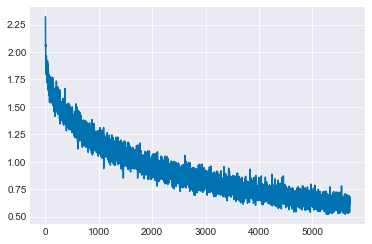

In [21]:
bestNet = SingleLayerNetSoftmax()
best_loss = bestNet.fit(x_train, y_train,
            lr=best_lr, reg=best_reg, mini_batch_sz=best_batch, n_epochs=300, verbose=2)
y_test_pred = bestNet.predict(x_test)

test_acc = bestNet.accuracy(y_test, y_test_pred)

print(f'Test accuracy {test_acc}')

plt.plot(best_loss)
plt.show()

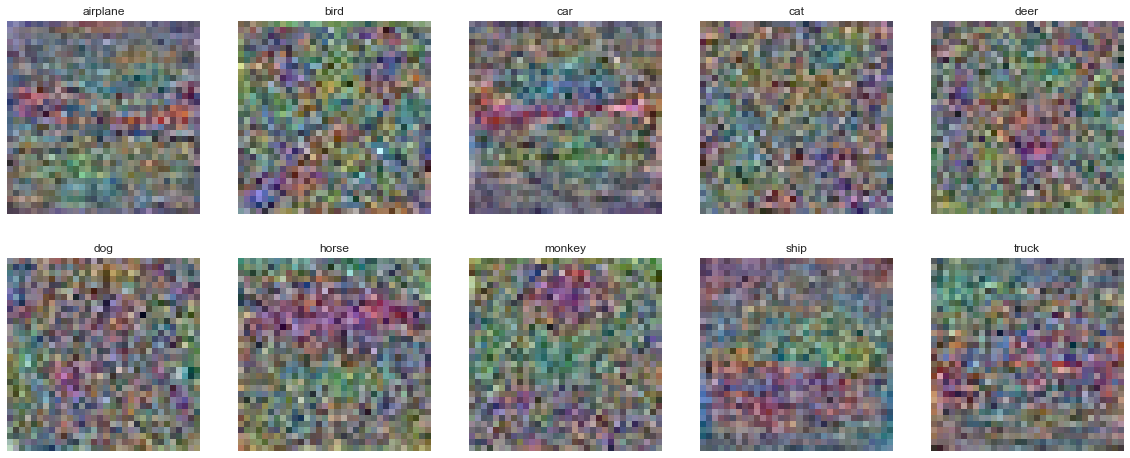

In [22]:
# We don't care about the bias wt
wts = bestNet.wts
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(20, 8))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)
  
  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))
  
  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

In [12]:
# Best values for plotting weights as found form trial and error.
best_lr = 0.0001
best_reg = 20
best_batch = 10

In [13]:
print(x_test.shape)

(500, 3072)


Starting to train network...There will be 300 epochs and 105000 iterations total, 350 iter/epoch.
  Completed iter 0/105000. Training loss: 33.02.
  Completed iter 100/105000. Training loss: 22.92.
  Completed iter 200/105000. Training loss: 16.12.
  Completed iter 300/105000. Training loss: 11.51.
  Completed iter 400/105000. Training loss: 8.46.
  Completed iter 500/105000. Training loss: 6.42.
  Completed iter 600/105000. Training loss: 5.09.
  Completed iter 700/105000. Training loss: 4.11.
  Completed iter 800/105000. Training loss: 3.50.
  Completed iter 900/105000. Training loss: 3.10.
  Completed iter 1000/105000. Training loss: 2.81.
  Completed iter 1100/105000. Training loss: 2.65.
  Completed iter 1200/105000. Training loss: 2.52.
  Completed iter 1300/105000. Training loss: 2.45.
  Completed iter 1400/105000. Training loss: 2.40.
  Completed iter 1500/105000. Training loss: 2.28.
  Completed iter 1600/105000. Training loss: 2.31.
  Completed iter 1700/105000. Training loss

  Completed iter 15800/105000. Training loss: 2.25.
  Completed iter 15900/105000. Training loss: 2.27.
  Completed iter 16000/105000. Training loss: 2.25.
  Completed iter 16100/105000. Training loss: 2.19.
  Completed iter 16200/105000. Training loss: 2.31.
  Completed iter 16300/105000. Training loss: 2.26.
  Completed iter 16400/105000. Training loss: 2.29.
  Completed iter 16500/105000. Training loss: 2.28.
  Completed iter 16600/105000. Training loss: 2.26.
  Completed iter 16700/105000. Training loss: 2.32.
  Completed iter 16800/105000. Training loss: 2.29.
  Completed iter 16900/105000. Training loss: 2.27.
  Completed iter 17000/105000. Training loss: 2.28.
  Completed iter 17100/105000. Training loss: 2.22.
  Completed iter 17200/105000. Training loss: 2.25.
  Completed iter 17300/105000. Training loss: 2.23.
  Completed iter 17400/105000. Training loss: 2.25.
  Completed iter 17500/105000. Training loss: 2.23.
  Completed iter 17600/105000. Training loss: 2.28.
  Completed 

  Completed iter 31900/105000. Training loss: 2.23.
  Completed iter 32000/105000. Training loss: 2.32.
  Completed iter 32100/105000. Training loss: 2.31.
  Completed iter 32200/105000. Training loss: 2.29.
  Completed iter 32300/105000. Training loss: 2.24.
  Completed iter 32400/105000. Training loss: 2.28.
  Completed iter 32500/105000. Training loss: 2.31.
  Completed iter 32600/105000. Training loss: 2.29.
  Completed iter 32700/105000. Training loss: 2.24.
  Completed iter 32800/105000. Training loss: 2.33.
  Completed iter 32900/105000. Training loss: 2.24.
  Completed iter 33000/105000. Training loss: 2.22.
  Completed iter 33100/105000. Training loss: 2.28.
  Completed iter 33200/105000. Training loss: 2.30.
  Completed iter 33300/105000. Training loss: 2.26.
  Completed iter 33400/105000. Training loss: 2.23.
  Completed iter 33500/105000. Training loss: 2.28.
  Completed iter 33600/105000. Training loss: 2.27.
  Completed iter 33700/105000. Training loss: 2.20.
  Completed 

  Completed iter 48000/105000. Training loss: 2.26.
  Completed iter 48100/105000. Training loss: 2.24.
  Completed iter 48200/105000. Training loss: 2.24.
  Completed iter 48300/105000. Training loss: 2.27.
  Completed iter 48400/105000. Training loss: 2.26.
  Completed iter 48500/105000. Training loss: 2.30.
  Completed iter 48600/105000. Training loss: 2.20.
  Completed iter 48700/105000. Training loss: 2.31.
  Completed iter 48800/105000. Training loss: 2.27.
  Completed iter 48900/105000. Training loss: 2.24.
  Completed iter 49000/105000. Training loss: 2.24.
  Completed iter 49100/105000. Training loss: 2.22.
  Completed iter 49200/105000. Training loss: 2.27.
  Completed iter 49300/105000. Training loss: 2.22.
  Completed iter 49400/105000. Training loss: 2.30.
  Completed iter 49500/105000. Training loss: 2.29.
  Completed iter 49600/105000. Training loss: 2.30.
  Completed iter 49700/105000. Training loss: 2.26.
  Completed iter 49800/105000. Training loss: 2.29.
  Completed 

  Completed iter 64100/105000. Training loss: 2.25.
  Completed iter 64200/105000. Training loss: 2.25.
  Completed iter 64300/105000. Training loss: 2.26.
  Completed iter 64400/105000. Training loss: 2.28.
  Completed iter 64500/105000. Training loss: 2.27.
  Completed iter 64600/105000. Training loss: 2.25.
  Completed iter 64700/105000. Training loss: 2.27.
  Completed iter 64800/105000. Training loss: 2.30.
  Completed iter 64900/105000. Training loss: 2.20.
  Completed iter 65000/105000. Training loss: 2.27.
  Completed iter 65100/105000. Training loss: 2.31.
  Completed iter 65200/105000. Training loss: 2.28.
  Completed iter 65300/105000. Training loss: 2.22.
  Completed iter 65400/105000. Training loss: 2.29.
  Completed iter 65500/105000. Training loss: 2.22.
  Completed iter 65600/105000. Training loss: 2.28.
  Completed iter 65700/105000. Training loss: 2.25.
  Completed iter 65800/105000. Training loss: 2.30.
  Completed iter 65900/105000. Training loss: 2.25.
  Completed 

  Completed iter 80200/105000. Training loss: 2.26.
  Completed iter 80300/105000. Training loss: 2.28.
  Completed iter 80400/105000. Training loss: 2.25.
  Completed iter 80500/105000. Training loss: 2.30.
  Completed iter 80600/105000. Training loss: 2.20.
  Completed iter 80700/105000. Training loss: 2.24.
  Completed iter 80800/105000. Training loss: 2.20.
  Completed iter 80900/105000. Training loss: 2.22.
  Completed iter 81000/105000. Training loss: 2.16.
  Completed iter 81100/105000. Training loss: 2.22.
  Completed iter 81200/105000. Training loss: 2.21.
  Completed iter 81300/105000. Training loss: 2.26.
  Completed iter 81400/105000. Training loss: 2.25.
  Completed iter 81500/105000. Training loss: 2.26.
  Completed iter 81600/105000. Training loss: 2.28.
  Completed iter 81700/105000. Training loss: 2.23.
  Completed iter 81800/105000. Training loss: 2.20.
  Completed iter 81900/105000. Training loss: 2.23.
  Completed iter 82000/105000. Training loss: 2.28.
  Completed 

  Completed iter 96600/105000. Training loss: 2.30.
  Completed iter 96700/105000. Training loss: 2.25.
  Completed iter 96800/105000. Training loss: 2.26.
  Completed iter 96900/105000. Training loss: 2.33.
  Completed iter 97000/105000. Training loss: 2.30.
  Completed iter 97100/105000. Training loss: 2.30.
  Completed iter 97200/105000. Training loss: 2.24.
  Completed iter 97300/105000. Training loss: 2.27.
  Completed iter 97400/105000. Training loss: 2.22.
  Completed iter 97500/105000. Training loss: 2.31.
  Completed iter 97600/105000. Training loss: 2.28.
  Completed iter 97700/105000. Training loss: 2.26.
  Completed iter 97800/105000. Training loss: 2.23.
  Completed iter 97900/105000. Training loss: 2.26.
  Completed iter 98000/105000. Training loss: 2.27.
  Completed iter 98100/105000. Training loss: 2.32.
  Completed iter 98200/105000. Training loss: 2.28.
  Completed iter 98300/105000. Training loss: 2.29.
  Completed iter 98400/105000. Training loss: 2.20.
  Completed 

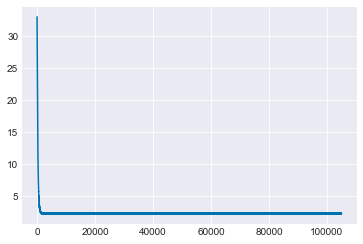

In [14]:
bestNet = SingleLayerNetSoftmax()
best_loss = bestNet.fit(x_train, y_train,
            lr=best_lr, reg=best_reg, mini_batch_sz=best_batch, n_epochs=300, verbose=2)
y_test_pred = bestNet.predict(x_test)

test_acc = bestNet.accuracy(y_test, y_test_pred)

print(f'Test accuracy {test_acc}')

plt.plot(best_loss)
plt.show()

### d. Visualize learned weights

**TODO:** Run the following code that plots the network weights going to each output neuron. If all goes well, you should see something really cool! Include the plot in your submitted project to show me what you got!

**Note:** the quality of your visualizations will depend on:
- The quality of the hyperparameters that you got via grid search.
- How many epochs that you trained the network before plotting the weights

One extension idea: is to find the combination of the above that result in the best visualizations.

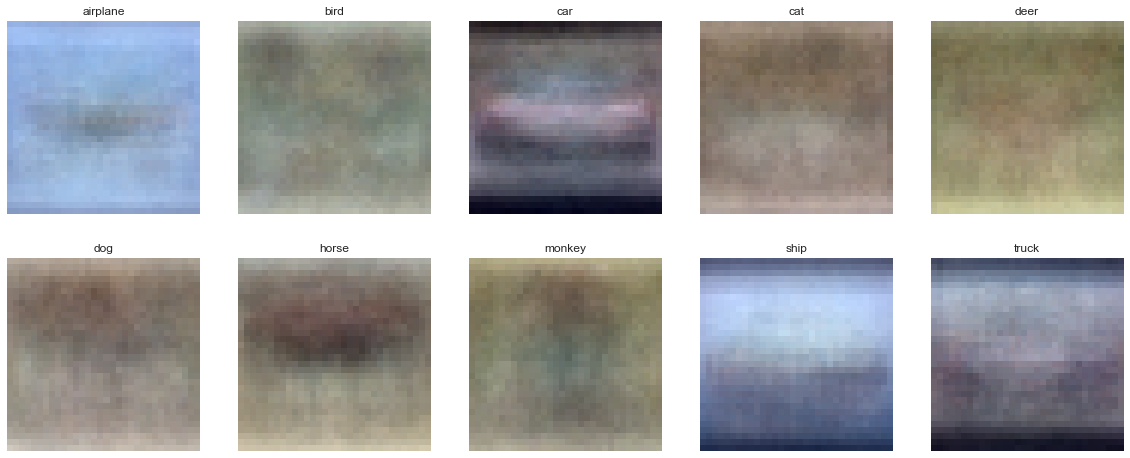

In [15]:
# We don't care about the bias wt
wts = bestNet.wts
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(20, 8))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)
  
  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))
  
  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])